# Lightcone structure of the many-body wave function

In the preceding section we introduced the Lieb-Robinson metric

$$
    g\left(\chi, t\right | \phi_{loc}, 0) = 
    \int_0^t d\tau \left\langle \chi \right| U_1 \left(\tau\right) \left| \phi_{loc} \right\rangle \left\langle \phi_{loc} \right| U_1^{\dagger} \left(\tau\right) \left| \chi \right \rangle - a_{cut},
$$

see {eq}`lr_metric_eq`. It defines a lightcone whose interior consists of all modes $\chi$ such that

$$
    g\left(\chi, t\right | \phi_{loc}, 0) \geq 0.
$$

At the end of the previous section we have shown that these modes $\chi$ have non-negligible average intensity of coupling to evolution generated by interaction at a local site $\phi_{loc}$, during the time interval $\left[0,t\right]$. 

This lightcone definition is correct for arbitrary initial many-body state at $t=0$. However, when computing the quantum qynamics inside this lightcone, one should take into account the fact that the modes outside the lightcone exercise the free motion. So that when these modes enter the lightcone at later times, their quantum state is different from the initial one at $t=0$.

This free motion outside the lightcone can by taken into account by switching to the interaction picture with respect to the free bath Hamiltonian

$$
  \widehat{H}_{b} =  \sum\limits_{i=0}^{\infty} (\varepsilon a^{\dagger}_{i} a_{i} + h a^{\dagger}_{i+1} a_{i} + h a^{\dagger}_{i} a_{i+1})    
$$ (free_bath)

## Illustrative example

In the case of the driven atom inside the waveguide, {eq}`quench_hamiltonian`, the interaction picture is

$$
    H\left(t\right) = E_{at}  \sigma_{z} + \sigma_{x} \cdot f(t) + h \sigma_{+} a_{0}\left(t\right) + h a^{\dagger}_{0}\left(t\right) \sigma_{-}, 
$$ (quench_interaction_pic)

with the relation {eq}`a_0_int`, which we repeat here for convenience:

$$
   a_0\left(t\right) = \sum_{k=0}^\infty \phi_k\left(t\right) a_k.
$$ 

In the case of general local interaction we have

$$
   a_{loc}\left(t\right) = \sum_{k=0}^\infty \phi_{loc}\left(k, t\right) a_k
$$ 

with initial condition $\phi_{loc}\left(k, t=0\right) = \phi_{loc}\left(k\right)$.

## Lieb-Robinson metric in the interaction picture

The treatment of the {ref}`lc_deriv_through_intensity` applies here. In particular, the first line of {eq}`intensity_computed` yields

$$
    I\left(t\right) = \int_0^t d\tau \left\langle \chi\left(-t\right)\right| \phi\left(-\tau\right) \left\rangle \right\langle \phi\left(-\tau\right) \left|\chi\left(-t\right)\right\rangle \\
    = \int_0^t d\tau \left\langle \chi_{int} | \phi^{\ast}\left(\tau\right) \right\rangle \left\langle \phi^{\ast}\left(\tau\right) | \chi_{int}\right\rangle,
$$

where the trial mode in the interaction picture is $\widehat{\chi}_{int} = \sum_k \chi_{int}\left(k\right) a_k$.

Therefore, we introduce the density operator of the forward lightcone in the interaction picture

$$
    \widehat{\rho}_{int+}\left(t\right) = \int_0^t d\tau \left|\phi^{\ast}\left(\tau\right)\right\rangle\left\langle \phi^{\ast}\left(\tau\right)\right| \\
    = \left(\widehat{\rho}_{+}\left(t\right)\right)^{\ast},
$$

where the second line shows its relation to the corresponding density operator in the Schrodinger picture.

The Lieb-Robinson metric in the interaction picture becomes

$$
    g\left(\chi_{int}, t\right | \phi_{loc}, 0) = \left\langle \chi_{int} \right| \widehat{\rho}_{int+}\left(t\right) \left| \chi_{int} \right\rangle 
        - a_{cut}.
$$

Here $a_{cut}$ should be definely relatively to the maximally significant mode, see {ref}`rel_treshold`


## Test calculation for the illustrative example

Let us check that in the interaction picture the non-vacuum initial condition works well with the lightcone.

Since the $\widehat{\rho}_{+}$ and $\widehat{\rho}_{int+}$ are simply complex conjugate of each other, and the site-local modes are real, the code to estimate the lightcone is almost the same as in {ref}`test_apriori_lc`, which we summarize as:


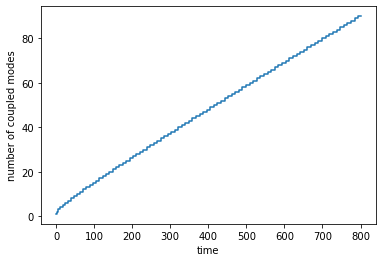

In [1]:
##### stage 1: sovle for lightcone wavepackets

import numpy as np
import tools

tmax = 800
dt = 0.01
t = np.arange(start = 0, stop = tmax, step = dt)
nt1 = t.size

ns = 100 # number of chain sites we keep

h = 0.05 # chain hopping
e = 1.0  # chain on-site energy

H1 = tools.tridiag([e]*ns, [h]*(ns-1)) # Hamiltonian for free propagation of a single quantum

phi_ini = np.zeros(ns, dtype = np.cdouble)
phi_ini[0] = 1 # initially quantum is on the site 0

psi_lc = np.zeros((ns, nt1), dtype = np.cdouble) # Here we store the propagated orbitals

def H1t(t):
    return H1

for i, psi in tools.evolution(start_index = 0, end_index = nt1, H = H1t, dt = dt, initial_state = phi_ini):
    psi_lc[:, i] = np.copy(psi)
    
##### stage 2: find times when new sites couple

r_cut = 10**(-6)

ti = [0]
rho_plus = np.zeros((ns, ns), dtype = np.cdouble)
j = 1
for i in range(nt1-1):
    # update rho_plus
    psi = tools.as_column_vector(psi_lc[:, i]).conj() # the only difference
    rho_plus += tools.dyad(psi, psi) * dt
    # find max eigenvalue
    pi_max, _ = tools.find_largest_eigs(rho_plus, 1)
    # check whether we are inside the lightcone
    site_sig = rho_plus[j + 1, j + 1]
    lr_metric = site_sig - r_cut * pi_max
    if lr_metric > 0:
        ti.append(i)
        j += 1
        if j==ns-1:
            # if all sites are coupled
            break

if ti[-1] < nt1-1:
    ti.append(nt1-1)
    
###### stage 3: visuatize number of coupled modes vs time

x = []
y = []

for i in range(len(ti)-1):
    x.append(t[ti[i]])
    x.append(t[ti[i+1]])
    y.append(i+1)
    y.append(i+1)

import matplotlib.pyplot as plt
plt.xlabel('time')
plt.ylabel('number of coupled modes')

plt.plot(x, y)

The interaction-picture Hamiltonian after restriction to the lightcone looks like (no driving):

$$
    H\left(t\right) = E_{at}  \sigma_{z} + h \sigma_{+} \sum_{k=0}^{m\left(t\right)}\phi_k\left(t\right)a_k + h \sum_{k=0}^{m\left(t\right)}\phi_k^{\ast}\left(t\right) a^{\dagger}_k \sigma_{-}, 
$$ (quench_interaction_pic_lc)

We take the initial condition that the site 3 is excited to a $5$-photon state:

$$
\Psi\left(t=0\right) = \left|0\right\rangle_{at} \otimes \left(a^{\dagger}_3\right)^5 \left| 0 \right\rangle
$$

From the plot of $m\left(t\right)$ on a smaller time range:

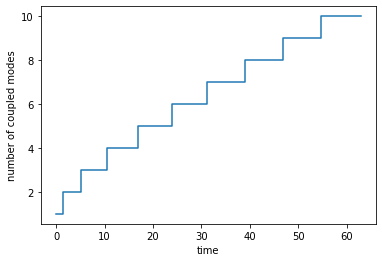

In [2]:
plt.xlabel('time')
plt.ylabel('number of coupled modes')

plt.plot(x[:20], y[:20])

we see that that the initial state of site 3 will start to interact with the atom around time $t=10$.

Let us solve first the full Hamiltonian:

In [3]:
import secondquant as sq
hs_atom = sq.fock_space(num_modes = 1, max_total_occupation = 1, statistics = 'Bose')
m = 10 
n = 7 
fs_chain = sq.fock_space(num_modes = m, max_total_occupation = n, statistics = 'Bose') 
hs_joint = sq.fock_space_kron(hs_atom, fs_chain)
b_hat = hs_joint.annihilate
b_hat_dag = hs_joint.create
sigma_m = b_hat[0]
sigma_p = b_hat_dag[0]
sigma_x = hs_joint.sigmax(0)
a_hat = b_hat[1:]
a_hat_dag = b_hat_dag[1:]

Eat = 1.0
h = 0.05
e = 1.0

Hconst = Eat * sigma_p @ sigma_m + h * sigma_p @ a_hat[0] + h * sigma_m @ a_hat_dag[0] \
    + e * sum([a_hat_dag[i] @ a_hat[i] for i in range(m)]) \
    + h * sum([a_hat_dag[i + 1] @ a_hat[i] + a_hat_dag[i] @ a_hat[i + 1] for i in range(m-1)])

def H(t):
    return Hconst

def Hi(ti):
    return H(ti * dt + dt/2)

# state with only site 3 occupied with 5 photons
occupations = np.zeros(m + 1, dtype = np.int32)
occupations[3 + 1] = 5
K = hs_joint.dimension
psi_ini = np.zeros(K, dtype = complex)
psi_ini[hs_joint.index(occupations)] = 1 

tmax = 60
dt = 0.01
t = np.arange(start = 0, stop = tmax, step = dt)
nt = t.size

nq = np.zeros(nt)

for i, psi in tools.evolution(start_index = 0, end_index = nt, H = Hi, dt = dt, initial_state = psi_ini):
    nq[i] = (np.conj(psi) @ sigma_p @ sigma_m @ psi).real

Then let us solve using {eq}`quench_interaction_pic_lc`. We base our code on the example {ref}`solve_inside_lc`:

Text(0, 0.5, 'occupation of qubit')

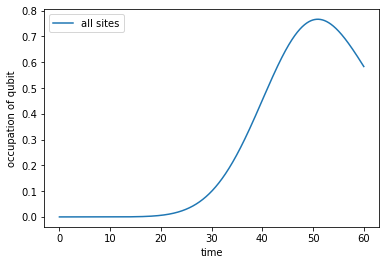

In [4]:
plt.plot(t, nq, label = 'all sites')
plt.legend()
plt.xlabel('time')
plt.ylabel('occupation of qubit')

In [5]:
nq2 = np.zeros(nt)

def eval():
    
    psi_begin = np.copy(psi_ini)
    
    for j in range(len(ti)-1):
        a = ti[j]
        b = ti[j+1]
    
        if a>nt-1:
            return
        b = min(b, nt-1)
    
        def Hmi(ti):
            a_int = sum([a_hat[i] * psi_lc[i, ti] for i in range(j + 1)]) 
            return Eat * sigma_p @ sigma_m \
                + h * sigma_p @ a_int + h * sigma_m @ a_int.conj().T
    
        for i, psi in tools.evolution(start_index = a, end_index = b, H = Hmi, dt = dt, initial_state = psi_begin):
            nq2[i] = (np.conj(psi) @ sigma_p @ sigma_m @ psi).real
            
        psi_begin = psi
        
eval()

Text(0, 0.5, 'occupation of qubit')

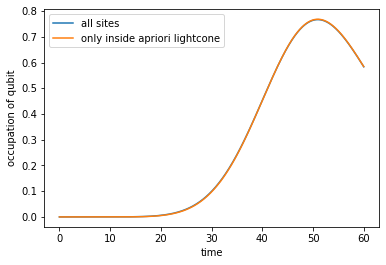

In [6]:
plt.plot(t, nq, label = 'all sites')
plt.plot(t[:-2], nq2[:-2], label = 'only inside apriori lightcone')
plt.legend()
plt.xlabel('time')
plt.ylabel('occupation of qubit')

## The lightcone describes the structure of entanglement of the whole many-body wavefunction

When we employ the lightcone-restricted Hamiltonian in the interaction picture, we actually do not discard any degrees of freedom. 
Instead, we neglect entanglement between the degrees of freedom when its statistical significance is below treshold, see the picture:

```{image} lightcone_wavefunction2.png
:width: 50%
```

Here blue line is a degree of freedom of open system (atom). Salmon lines are sites of the chain (environment). The initial wavefunction $\left|\Psi\left(t=0\right)\right\rangle$ may by arbitrary and may entangle all the degrees of freedom. The additional entanglement due to the local interaction quench is represented by gray block (left part of the picture). The validity of lightcone in the interaction picture implies that the interaction-induced entanglement spreads gradually over the environment's degrees of freedom (right part of the picture), up to the statistical significance treshold $a_{cut}$

This means that when we restrict the interaction Hamiltonian to the lightcone interior, the obserable properties of all degrees of freedom (for open system, inside lightcone, and outside lightcone) are faithfully reproduced.  

Let us test this for the occupations of the chain sites. We begin with the full computation (with all the sites included):

Text(0, 0.5, 'occupation of chain sites')

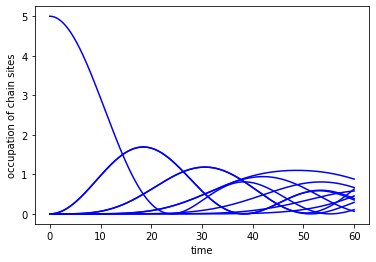

In [7]:
nc = np.zeros((nt, m))

for i, psi in tools.evolution(start_index = 0, end_index = nt, H = Hi, dt = dt, initial_state = psi_ini):
    for j in range(m):
        nc[i, j] = (np.conj(psi) @ a_hat_dag[j] @ a_hat[j] @ psi).real
        
# visualize the results:

for j in range(m):
    plt.plot(t, nc[:, j], 'b')
    
plt.xlabel('time')
plt.ylabel('occupation of chain sites')

Then we compare with the lightcone-restricted Hamiltonian.

However first we need to find the interaction picture for $a_k$:

$$
   a_k\left(t\right) = \sum_{i=0}^\infty \phi_{ki}\left(t\right) a_i,
$$ 

where $\phi_{ki}\left(t=0\right)=\delta_{ki}$ and $\phi_{ki}\left(t\right) = \left\langle k \right| U_1 \left(t\right) \left| i \right\rangle$.

Let us compute $\phi_{ki}\left(t\right)$:



In [8]:
phi_ki = np.zeros((ns, nt, m), dtype = np.cdouble)

def H1t(t):
    return H1

for k in range(m):
    phi1_ini = np.zeros(ns, dtype = np.cdouble)
    phi1_ini[k] = 1.0 # initially quantum is on the site k

    for i, psi in tools.evolution(start_index = 0, end_index = nt, H = H1t, dt = dt, initial_state = phi1_ini):
        phi_ki[:, i, k] = np.copy(psi)

Now the occupations:

In [9]:
nc2 = np.zeros((nt, m))

def eval():
    
    psi_begin = np.copy(psi_ini)
    
    for j in range(len(ti)-1):
        a = ti[j]
        b = ti[j+1]
    
        if a>nt-1:
            return
        b = min(b, nt-1)
    
        def Hmi(ti):
            a_int = sum([a_hat[i] * psi_lc[i, ti] for i in range(j + 1)]) 
            return Eat * sigma_p @ sigma_m \
                + h * sigma_p @ a_int + h * sigma_m @ a_int.conj().T
    
        for i, psi in tools.evolution(start_index = a, end_index = b, H = Hmi, dt = dt, initial_state = psi_begin):
            for k in range(m):
                a_k_int = sum([a_hat[p] * phi_ki[p, i, k] for p in range(m)])
                nc2[i, k] = (np.conj(psi) @ a_k_int.T.conj() @ a_k_int @ psi).real
            
        psi_begin = psi
        
eval()

Text(0, 0.5, 'occupation of chain sites')

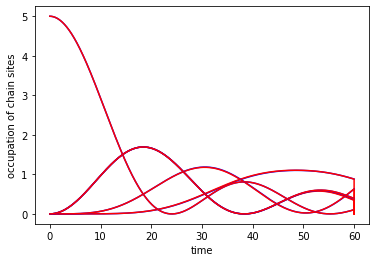

In [10]:
for j in range(m//2):
    plt.plot(t, nc[:, j], 'b')
    plt.plot(t, nc2[:, j], 'r')
    
plt.xlabel('time')
plt.ylabel('occupation of chain sites')


The occupancies coincide! The discrepancy only appears near the chain end since it is truncated (it should be semiinfinite):

Text(0, 0.5, 'occupation of chain sites')

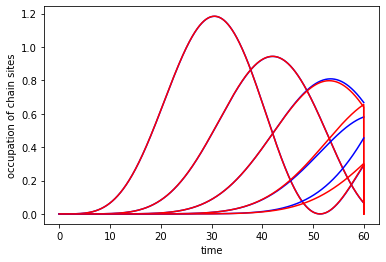

In [11]:
for j in range(m//2, m):
    plt.plot(t, nc[:, j], 'b')
    plt.plot(t, nc2[:, j], 'r')
    
plt.xlabel('time')
plt.ylabel('occupation of chain sites')

Therefore, this numerical result supports the conclusion that the whole many-body wavefunction has the lightcone structure.